# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import glob
import os
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

**Specify the `exportdate` below**

In [2]:
exportdate = pd.Timestamp('2023-4-5T12')

# Computing Feature 1: Warningsign

## Importing dataset

Place all your "file.csv" files in a folder named files and then use its path as mentioned below

In [3]:
# use list comprehension to read all files
path = r"files"
all_files = [pd.read_csv(filename, dtype={'BizDomainId': 'string', 'CaseId': 'string'}, low_memory=False) for filename in glob.glob(os.path.join(path , "*.csv"))]

# combine dataframes into a single dataframe
df = pd.concat(all_files, axis=0, ignore_index=True)

# rename columns
df = df.rename(columns={'IsDeleted':'IsDeletedCase','Id':'CaseId' , 'Id.1':'ActivityId','IsDeleted.1':'IsDeletedActivity','RegisterTime':'RegisterTimeCase','Status':'StatusCase',
                         'DoneTime': 'DoneTimeCase','RegisterDate':'RegisterDateActivity','IsDone':'IsDoneActivity', 'DoneDate':'DoneDateActivity'})

# manipulate columns
df['BizDomainId'] = df['BizDomainId'].astype('string')
df['CaseId'] = df['CaseId'].astype('string')
df['BizDomainId'] = df['BizDomainId'].str.lower()
df['CaseId'] = df['CaseId'].str.lower()

df['DoneDateActivity'] = np.where(df['IsDoneActivity']==0 , np.nan ,df['DoneDateActivity'])
df['CaseFinishTime']=np.where(df['StatusCase']==2 , df['DoneTimeCase'] , None)
df['temp'] = np.nanmax(df[['RegisterDateActivity' , 'DoneDateActivity' , 'CaseFinishTime' , 'RegisterTimeCase']].fillna(value='00'),axis=1)
df['temp'] = pd.to_datetime(df['temp'] , errors='coerce',format = '%Y%m%d %H:%M:%S')

df = df[~pd.isna(df['temp'])]
del df['temp']

# convert date/time columns to datetime dtype
df['RegisterDateActivity'] = pd.to_datetime(df['RegisterDateActivity'])
df['DoneDateActivity'] = pd.to_datetime(df['DoneDateActivity'])
df['RegisterTimeCase'] = pd.to_datetime(df['RegisterTimeCase'])
df['CaseFinishTime'] = pd.to_datetime(df['CaseFinishTime'])

# drop columns
df.drop(['ActivityId' , 'DoneTimeCase'], axis=1, inplace=True)

# print results
df.head()

,BizDomainId,CaseId,IsDeletedCase,RegisterTimeCase,StatusCase,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,CaseFinishTime
0,b2f919c6-9842-4d8d-ad98-4a94a7a1013b,f1e83159-71b1-4438-9e97-827f391427d8,0,2023-02-27 08:29:06,2,0.0,2023-03-03 07:38:59,1.0,2023-02-28 06:00:38,2023-03-12 03:04:41
1,ffc39d03-0fcf-467d-88cc-b645ad92bf7c,256255c1-ab82-4d73-9ca8-43f2aaad895f,0,2023-02-05 09:00:09,2,0.0,2023-02-08 08:31:55,1.0,2023-02-12 06:07:36,2023-03-11 06:32:40
2,b95b1c5a-1079-4e63-8120-bbc62e5ccf97,7755917d-013d-41fb-a749-7dc5e5dedab9,0,2023-03-22 12:53:23,2,0.0,2023-04-04 07:49:06,1.0,2023-04-04 07:49:06,2023-04-04 07:51:13
3,b2f919c6-9842-4d8d-ad98-4a94a7a1013b,97e90022-70f0-4570-ab79-f24398d143d1,0,2023-04-05 05:05:16,1,0.0,2023-04-04 11:37:11,0.0,NaT,NaT
4,1356c5ea-d3d3-4dc1-a1bc-c571b408059b,b1d44161-13c5-4110-987a-af846e64c93b,0,2023-02-26 12:05:30,2,0.0,2023-02-26 12:10:12,1.0,2023-02-26 12:20:18,2023-02-27 07:47:32


## Joining ExpireDate Dataset

In [4]:
# Load and merge the expiration date data
ExpireDate = pd.read_csv(r"Training Data\ExpireDate.csv", dtype={"Id": str})
ExpireDate = ExpireDate.rename(columns={'Id':'BizDomainId','RegisterTime':'BizRegisterDate','ExpirationDate':'BizExpireDate' , 'LastAccessTime':'BizAccessDate'})
ExpireDate['BizDomainId'] = ExpireDate['BizDomainId'].str.lower()
df = pd.merge(df, ExpireDate, how='left')

# Convert datetime columns
date_columns = ['BizRegisterDate', 'BizExpireDate', 'BizAccessDate']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# Determine whether the business is expired
df['BizIsExpired?'] = np.where(df['BizExpireDate'] >= exportdate, 0, 1)

# Keep the bizdomains that last longer than 2 months
from dateutil.relativedelta import relativedelta
df = df[df['BizRegisterDate'] <= (exportdate - relativedelta(months=2))]

# Delete data where IsDeletedCase=1 and StatusCase=1 (Pending)
mask = df.query('IsDeletedCase == 1 and StatusCase == 1').index
shape1 = len(df)
df = df.loc[~df.index.isin(mask)]
shape2 = len(df)
print(f"Number of deleted cases: {shape1-shape2}, number of rows before: {shape1}, number of rows after: {shape2}")


Number of deleted cases: 4995, number of rows before: 87503, number of rows after: 82508


In [5]:
def apply_function(df):
    mask = (df['StatusCase'] == 1) & (df['IsDeletedCase'] == 0)
    expired_mask = mask & (df['BizIsExpired?'] == 1)
    df.loc[expired_mask, 'CaseFinishTime'] = np.minimum(df.loc[expired_mask, 'BizExpireDate'], df.loc[expired_mask, 'BizAccessDate'])
    df.loc[expired_mask & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = df.loc[expired_mask, 'CaseFinishTime']
    df.loc[mask & ~(df['BizIsExpired?'] == 1), 'CaseFinishTime'] = exportdate
    df.loc[mask & ~(df['BizIsExpired?'] == 1) & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = exportdate
    df.drop(columns=['BizAccessDate' , 'BizExpireDate' , 'BizRegisterDate'], inplace=True)
    return df

df = apply_function(df)
df.head()

,BizDomainId,CaseId,IsDeletedCase,RegisterTimeCase,StatusCase,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,CaseFinishTime,BizIsExpired?
0,b2f919c6-9842-4d8d-ad98-4a94a7a1013b,f1e83159-71b1-4438-9e97-827f391427d8,0,2023-02-27 08:29:06,2,0.0,2023-03-03 07:38:59,1.0,2023-02-28 06:00:38,2023-03-12 03:04:41,0
1,ffc39d03-0fcf-467d-88cc-b645ad92bf7c,256255c1-ab82-4d73-9ca8-43f2aaad895f,0,2023-02-05 09:00:09,2,0.0,2023-02-08 08:31:55,1.0,2023-02-12 06:07:36,2023-03-11 06:32:40,0
2,b95b1c5a-1079-4e63-8120-bbc62e5ccf97,7755917d-013d-41fb-a749-7dc5e5dedab9,0,2023-03-22 12:53:23,2,0.0,2023-04-04 07:49:06,1.0,2023-04-04 07:49:06,2023-04-04 07:51:13,0
3,b2f919c6-9842-4d8d-ad98-4a94a7a1013b,97e90022-70f0-4570-ab79-f24398d143d1,0,2023-04-05 05:05:16,1,0.0,2023-04-04 11:37:11,0.0,2023-04-05 12:00:00,2023-04-05 12:00:00,0
4,1356c5ea-d3d3-4dc1-a1bc-c571b408059b,b1d44161-13c5-4110-987a-af846e64c93b,0,2023-02-26 12:05:30,2,0.0,2023-02-26 12:10:12,1.0,2023-02-26 12:20:18,2023-02-27 07:47:32,0


Function for Fixing the order of the times of occurrence

DealStartTime<ActivityStartTime<ActivityFinishTime<DealFinishTime

In [6]:
df['RegisterTimeCase']=np.minimum(df['RegisterTimeCase'] , df['CaseFinishTime'])
mask = ~pd.isna(df['RegisterDateActivity'])
df.loc[mask, 'RegisterDateActivity'] = np.maximum(df.loc[mask, 'RegisterTimeCase'] ,  
                                     np.minimum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask,'CaseFinishTime']))
df.loc[mask , 'DoneDateActivity'] = np.minimum(df.loc[mask,'CaseFinishTime'] ,  
                                     np.maximum(df.loc[mask,'RegisterTimeCase'] , df.loc[mask,'DoneDateActivity']))
df.loc[mask,'DoneDateActivity'] = np.maximum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask , 'DoneDateActivity'])

Activity: IsDone=0, IsDeleted=1

In [7]:
mask = (df['IsDoneActivity']==0) & (df['IsDeletedActivity']==1)
df = df.loc[~mask ,:]

Completing finish time of activities

In [8]:
# Calculate average of other activities of Case
df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
df['avg_diff_Case'] = df['diff'].groupby(df['CaseId']).transform(lambda x: np.nanmean(x))
mask_Case = pd.isna(df['DoneDateActivity']) & (df.groupby('CaseId')['CaseId'].transform('size') > 1)
df.loc[mask_Case, 'DoneDateActivity'] = df.loc[mask_Case, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_Case, 'avg_diff_Case'], unit='s')
df.drop(columns=['diff', 'avg_diff_Case'], inplace=True)

# Calculate average of other activities of biz
df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
df['avg_diff_biz'] = df['diff'].groupby(df['BizDomainId']).transform(lambda x: np.nanmean(x))
mask_biz = pd.isna(df['DoneDateActivity'])
df.loc[mask_biz, 'DoneDateActivity'] = df.loc[mask_biz, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_biz, 'avg_diff_biz'], unit='s')
df.drop(columns=['diff', 'avg_diff_biz'], inplace=True)

# Clip DoneDateActivity to CaseFinishTime
df['DoneDateActivity'] = np.minimum(df['DoneDateActivity'], df['CaseFinishTime'])

In [9]:
df.shape

(79998, 11)

## Export Cleaned Dataset

Export data based on the shape of the df, each 1,000,000 rows should be saved a separate csv file

In [10]:
os.makedirs('files_cleaned', exist_ok=True)
for i, chunk in enumerate(df.groupby(np.arange(len(df)) // 1000000)):
    chunk[1].to_csv(f'files_cleaned/df_file_cleaned{i+1}.csv', index=False)

**Importing the cleaned dataset**

Change the directory of exported data to `files_cleaned` and then use the cell below if you desire to use them. Exporting should be done because the cleaned dataset will be used in future Feature Extractions.

In [11]:
# path = r"files_cleaned" # use your path
# all_files = glob.glob(os.path.join(path , "*.csv"))

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=0, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)
# df.loc[:, ['RegisterTimeCase' , 'CaseFinishTime','RegisterDateActivity','DoneDateActivity']] = df.loc[:,['RegisterTimeCase' , 'CaseFinishTime','RegisterDateActivity','DoneDateActivity']].apply(pd.to_datetime)
# df.head()

Function for calculating the metric of proportion of warning time to total deal time

In [12]:
def merge_times(intervals):
    intervals.sort(key=lambda x: x[0])

    res = [intervals[0]]
    for idx in range(1, len(intervals)):
        curr = intervals[idx]
        prev = res[-1]

        # Check for overlap
        if prev[1] < curr[0]:  # No overlap
            res.append(curr)
        else:
            # Overlap, update end time
            prev[1] = max(prev[1], curr[1])

    return res

def no_warning_ratio(start_time, end_time, intervals):
    '''
    input:
    start_time = RegisterTime of a Case
    end_time = CaseFinishTime
    intervals = related intervals for activities on a specific Case
    
    ----------------------
    
    output:
    a dictionary with the following keys:
    - 'no_warning_ratio': ratio of (not showing warning signal)/(duration of the Case)
    - 'Case_duration': duration of the Case in seconds
    '''
    end_time_int = pd.Timedelta(end_time - start_time).total_seconds()

    if pd.isna(intervals.iloc[0, 0]):
        return {'no_warning_ratio': 0, 'Case_duration': end_time_int}
    elif end_time_int == 0:
        return {'no_warning_ratio': 0, 'Case_duration': 0}
    else:
        intervals = intervals.sub(start_time).apply(lambda x: x.dt.total_seconds()).values.tolist()
        merged = merge_times(intervals)
        with_activity = np.sum(end - start for start, end in merged)
        ratio = with_activity / end_time_int
        return {'no_warning_ratio': ratio, 'Case_duration': end_time_int}


def metric_activation_function(df):
    '''
    input:
    dataframe of the groupby function applied to CaseIds
    
    ----------------------
    
    output:
    a dictionary with the following keys:
    - 'BizDomainId': the ID of the business domain
    - 'CaseId': the ID of the Case
    - 'metric': the no_warning_ratio for the Case
    - 'CaseDuration': the duration of the Case in seconds
    '''
    BizId = df.loc[:, 'BizDomainId'].values[0]
    CaseId = df.loc[:, 'CaseId'].values[0]
    start_time = df.loc[:, 'RegisterTimeCase'].values[0]
    end_time = df.loc[:, 'CaseFinishTime'].values[0]
    intervals = df.loc[:, ['RegisterDateActivity', 'DoneDateActivity']]
    res = no_warning_ratio(start_time, end_time, intervals)
    return {'BizDomainId': BizId, 'CaseId': CaseId, 'metric': res['no_warning_ratio'], 'CaseDuration': res['Case_duration']}


metric = df.groupby('CaseId').apply(metric_activation_function)
metric = pd.DataFrame(metric.tolist())

Aggregating for BizId by the means of Calculating expectation (weighted average)

In [13]:
def AggreagtorBizId(df):
    BizId=df.loc[:,'BizDomainId'].values[0]
    if np.sum(df['CaseDuration'])==0:
        return {'BizDomainId':BizId , 'no_warning_sign':0}
    else:
        return {'BizDomainId': BizId , 'no_warning_sign':
               np.sum(df['metric']*df['CaseDuration'])/df['CaseDuration'].sum()}
    
final_df = metric.groupby('BizDomainId').apply(AggreagtorBizId)
final_df = pd.DataFrame(final_df.tolist())

## Output Feature 1

In [14]:
final_df = pd.merge(final_df , df[['BizDomainId','BizIsExpired?']] , how='left')
final_df = final_df.drop_duplicates().rename(columns={'no_warning_sign':'WarningSign'})
final_df['WarningSign'] = 1-final_df['WarningSign']
os.makedirs('Notebooks Data Process', exist_ok=True)
final_df.to_csv('Notebooks Data Process/1. WarningSign.csv',index=0)

# Computing Other Features

importing cleaned files

In [15]:
path = r"files_cleaned" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = [pd.read_csv(filename,dtype={'BizDomainId': 'string', 'CaseId': 'string'},parse_dates=[
    'RegisterTimeCase' , 'CaseFinishTime','RegisterDateActivity','DoneDateActivity']) for filename in all_files]

file_cleaned = pd.concat(li, axis=0, ignore_index=True)
file_cleaned.head()

,BizDomainId,CaseId,IsDeletedCase,RegisterTimeCase,StatusCase,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,CaseFinishTime,BizIsExpired?
0,b2f919c6-9842-4d8d-ad98-4a94a7a1013b,f1e83159-71b1-4438-9e97-827f391427d8,0,2023-02-27 08:29:06,2,0.0,2023-03-03 07:38:59,1.0,2023-03-03 07:38:59,2023-03-12 03:04:41,0
1,ffc39d03-0fcf-467d-88cc-b645ad92bf7c,256255c1-ab82-4d73-9ca8-43f2aaad895f,0,2023-02-05 09:00:09,2,0.0,2023-02-08 08:31:55,1.0,2023-02-12 06:07:36,2023-03-11 06:32:40,0
2,b95b1c5a-1079-4e63-8120-bbc62e5ccf97,7755917d-013d-41fb-a749-7dc5e5dedab9,0,2023-03-22 12:53:23,2,0.0,2023-04-04 07:49:06,1.0,2023-04-04 07:49:06,2023-04-04 07:51:13,0
3,b2f919c6-9842-4d8d-ad98-4a94a7a1013b,97e90022-70f0-4570-ab79-f24398d143d1,0,2023-04-05 05:05:16,1,0.0,2023-04-05 05:05:16,0.0,2023-04-05 12:00:00,2023-04-05 12:00:00,0
4,1356c5ea-d3d3-4dc1-a1bc-c571b408059b,b1d44161-13c5-4110-987a-af846e64c93b,0,2023-02-26 12:05:30,2,0.0,2023-02-26 12:10:12,1.0,2023-02-26 12:20:18,2023-02-27 07:47:32,0


Importing Feature 1 Final Dataset and ExpireDataset

In [16]:
from dateutil.relativedelta import relativedelta
df = pd.read_csv(r"Notebooks Data Process/1. WarningSign.csv")
expire = pd.read_csv(r"Training Data/ExpireDate.csv").rename(columns={'Id':'BizdomainId'})
expire['BizdomainId'] = expire['BizdomainId'].str.lower()
expire['RegisterTime'] = pd.to_datetime(expire['RegisterTime'])
expire['ExpirationDate'] = pd.to_datetime(expire['ExpirationDate'])

expire = expire[expire['RegisterTime'] <= (exportdate - relativedelta(months=2))]
more_than_2months_biz = expire['BizdomainId'].tolist()
df = pd.merge(expire[['BizdomainId','RegisterTime','ExpirationDate']] , df , left_on = 'BizdomainId' ,
              right_on='BizDomainId' , how='left').drop(columns='BizDomainId').rename(
    columns={'BizdomainId':'BizDomainId'})
df['BizIsExpired?']=np.where(df['ExpirationDate']>=exportdate,0,1)
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1


## #Activities & #Deals

In [17]:
df5_1 = pd.read_csv(r"Training Data\Cases - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Cases - 2 Month ago.csv")
df5_1['BizDomainId'] = df5_1['BizDomainId'].str.lower()
df5_2['BizDomainId'] = df5_2['BizDomainId'].str.lower()
df5 = pd.merge(df5_1 , df5_2 , how='outer', on='BizDomainId')
df5['#Cases_2months'] = df5['LastMonth'].fillna(0)+df5['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df5[['BizDomainId' , '#Cases_2months']] , how='left' , on='BizDomainId')


df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")
df6_1['BizDomainId'] = df6_1['BizDomainId'].str.lower()
df6_2['BizDomainId'] = df6_2['BizDomainId'].str.lower()
df6 = pd.merge(df6_1 , df6_2 , how='outer', on='BizDomainId')
df6['#Activities_2months'] = df6['LastMonth'].fillna(0)+df6['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df6[['BizDomainId' , '#Activities_2months']] , how='left' , on='BizDomainId')
df_act = file_cleaned.groupby('BizDomainId')['CaseId'].agg('count').reset_index().rename(columns={'CaseId':'#Activities_files'})
df_Case = file_cleaned.groupby('BizDomainId')['CaseId'].nunique().reset_index().rename(columns={'CaseId':'#Cases_files'})
df = pd.merge(df , df_act , on = 'BizDomainId' , how='left')
df = pd.merge(df , df_Case , on = 'BizDomainId' , how='left')

df['#Cases'] = np.maximum(df['#Cases_2months'].fillna(0) , df['#Cases_files'].fillna(0))
df['#Activities'] = np.maximum(df['#Activities_2months'].fillna(0), df['#Activities_files'].fillna(0))
df.drop(columns=['#Cases_2months','#Cases_files','#Activities_2months','#Activities_files'],inplace=True)
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Cases,#Activities
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1,0.0,0.0
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1,0.0,0.0
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1,0.0,1.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1,0.0,0.0
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1,0.0,1.0


## Feature 2: ActiveUsers/AddedUsers

In [18]:
df_3 = pd.read_csv(r"Training Data\Active-Add-Ratio.csv",parse_dates = ['Date'])
df_3['BizdomainId'] = df_3['BizdomainId'].str.lower()
df_3 = df_3.query('Date <= @exportdate')
df_3['ActiveUsers/AddedUsers'] = df_3['ActiveUsers'] / df_3['TotalUsersAdded']
df_3 = df_3.groupby('BizdomainId')['ActiveUsers/AddedUsers'].mean().reset_index()

df = pd.merge(df, df_3.rename(columns={'BizdomainId': 'BizDomainId'})[['BizDomainId', 'ActiveUsers/AddedUsers']],
              how='left', on='BizDomainId')
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Cases,#Activities,ActiveUsers/AddedUsers
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.000000
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.375000
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1,0.0,1.0,0.320833
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1,0.0,0.0,0.000000
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1,0.0,1.0,0.181818


If a bizdomain has the following features:
1. Active
2. Not Expired
3. Null WarningSign

WarningSign should be one.

In [19]:
mask = (df['ActiveUsers/AddedUsers']>0) & pd.isna(df['WarningSign']) & (df['BizIsExpired?']==0)
df.loc[mask , 'WarningSign'] = 1

## Feature 3: TransformationSpeed related (Pending/Whole Case)

In [20]:
filenames = [r"Training Data\TransSpeed – PendingCase.csv", r"Training Data\TransSpeed – WholeCase.csv"]
filenames2 = [r"Training Data\TransSpeed - PendingCase.csv", r"Training Data\TransSpeed - WholeCase.csv"]
try:
    df41, df42 = [pd.read_csv(filename) for filename in filenames]
except FileNotFoundError:
    df41, df42 = [pd.read_csv(filename) for filename in filenames2]

df41['BizDomainId'] = df41['BizDomainId'].str.lower()
df42['BizDomainId'] = df42['BizDomainId'].str.lower()

df4 = df42.merge(df41, on='BizDomainId', how='left')
df4['PendingCase'].fillna(0, inplace=True)
df4['Pending/Whole_TransSpeed'] = df4['PendingCase'] / df4['WholeCase']

df = df.merge(df4[['BizDomainId', 'Pending/Whole_TransSpeed']], on='BizDomainId', how='left')

## Feature 4: CasesRatio

In [21]:
df5_1 = pd.read_csv(r"Training Data\Cases - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Cases - 2 Month ago.csv")
df5_1['BizDomainId'] = df5_1['BizDomainId'].str.lower()
df5_2['BizDomainId'] = df5_2['BizDomainId'].str.lower()

df5 = pd.merge(df5_1 , df5_2 , how='outer', on='BizDomainId')
df5['TwoMonthsAgo'].fillna(1 , inplace=True)
df5['LastMonth'].fillna(0 , inplace=True)
df5['CasesRatio'] = df5['LastMonth'] / df5['TwoMonthsAgo']

df = pd.merge(df , df5[['BizDomainId' , 'CasesRatio']] , how='left' , on='BizDomainId')
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Cases,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,CasesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.375000,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1,0.0,1.0,0.320833,NaN,NaN
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1,0.0,1.0,0.181818,NaN,NaN


## Feature 5: ActivitiesRatio

In [22]:
df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")
df6_1['BizDomainId'] = df6_1['BizDomainId'].str.lower()
df6_2['BizDomainId'] = df6_2['BizDomainId'].str.lower()

df6 = pd.merge(df6_1 , df6_2 , how='outer', on='BizDomainId')
df6['TwoMonthsAgo'].fillna(1 , inplace=True)
df6['LastMonth'].fillna(0 , inplace=True)
df6['ActivitiesRatio'] = df6['LastMonth'] / df6['TwoMonthsAgo']
df = pd.merge(df , df6[['BizDomainId' , 'ActivitiesRatio']] , how='left' , on='BizDomainId')
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Cases,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,CasesRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1,0.0,1.0,0.320833,NaN,NaN,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1,0.0,1.0,0.181818,NaN,NaN,0.0


Only BizDomains that exist more than 2 months and the features can be calculated for

In [23]:
df = df[df['BizDomainId'].isin(more_than_2months_biz)]
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Cases,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,CasesRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1,0.0,1.0,0.320833,NaN,NaN,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1,0.0,1.0,0.181818,NaN,NaN,0.0


## Output of other features

In [24]:
# os.mkdir('Notebooks Data Process')
df.to_csv('Notebooks Data Process/2. all features.csv',index=0)

# Feature Engineering

In [25]:
df = pd.read_csv(r"Notebooks Data Process/2. all features.csv")
df = df.dropna(subset='ActiveUsers/AddedUsers')
print('shape of new df:',df.shape)
print('\nnumber fo expired and actives:\n'+str(df['BizIsExpired?'].value_counts()))
df.head()

shape of new df: (3277, 11)

number fo expired and actives:
0    2117
1    1160
Name: BizIsExpired?, dtype: int64


,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Cases,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,CasesRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07 06:42:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07 06:32:00,2022-05-22 12:00:00,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08 11:44:00,2022-05-22 12:00:00,NaN,1,0.0,1.0,0.320833,NaN,NaN,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08 09:25:00,2022-05-23 12:00:00,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20 05:17:00,2022-05-23 12:00:00,NaN,1,0.0,1.0,0.181818,NaN,NaN,0.0


In [26]:
# WarningSign: 
## NaN values of this columns are replaced with 1
df.loc[: , 'WarningSign'].fillna(1 , inplace=True)

# ActivitiesRatio & CasesRatio
## Worst values are 0
## Bizdomains didnt register any activity/Case in the past 2 months
df.loc[: , 'CasesRatio'].fillna(0 , inplace=True)
df.loc[: , 'ActivitiesRatio'].fillna(0 , inplace=True)


# Pending/Whole_TransSpeed
## NaN means no Cases for the last 3 months
df['Pending/Whole_TransSpeed'].fillna(inplace=True , value=1)


# CasesRatio
name= 'CasesRatio'
df[name] = df[name].clip(upper=1)

# ActivitiesRatio
name= 'ActivitiesRatio'
df[name] = df[name].clip(upper=1)

## Making all Features Consistent
The higher the values in each columns, the better the bizdomain

In [27]:
df[['WarningSign' , 'Pending/Whole_TransSpeed']] = 1-df[['WarningSign' , 'Pending/Whole_TransSpeed']]

In [28]:
df.to_csv('Notebooks Data Process/3. Feature_Engineered.csv',index=0)

# Health Score

In [29]:
df = pd.read_csv(r'Notebooks Data Process/3. Feature_Engineered.csv').drop(columns=['RegisterTime' , 'ExpirationDate','BizIsExpired?'])
del df['#Cases']
del df['#Activities']
df.head()

# best practices & weights
best = [1 , 1 , 1 , 1 , 1 ]
weights_1 = [0.157400 , 0.210278 , 0.105956 , 0.287206 , 0.239160]

# Health Score
from scipy.spatial.distance import euclidean
df['Health_Score'] = np.around(1 - df.iloc[:,1:].apply(lambda x: euclidean(x , best , weights_1) , axis=1),decimals=4)*10

cols_to_round = df.columns.drop(['BizDomainId' , 'Health_Score'])
df.loc[: , cols_to_round] = np.around(df.loc[: , cols_to_round] , decimals=3)

df.head()

,BizDomainId,WarningSign,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,CasesRatio,ActivitiesRatio,Health_Score
0,28710004-7957-4cae-8528-2e45bd62bbe9,0.0,0.000000,0.0,0.0,0.0,0.000
1,1374a992-1317-4bd8-8129-874374a25f2b,0.0,0.375000,0.0,0.0,0.0,0.684
2,e522f481-9224-47d1-b248-ab00983cd1a3,0.0,0.320833,0.0,0.0,0.0,0.602
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,0.0,0.000000,0.0,0.0,0.0,0.000
4,a4a3f452-aa6d-4474-b032-82915f6fd267,0.0,0.181818,0.0,0.0,0.0,0.365


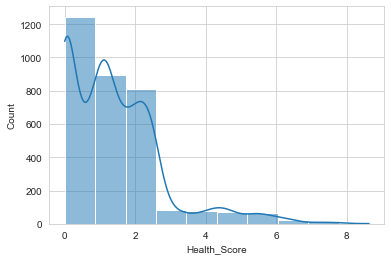

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.set_style('whitegrid')
sns.histplot(df['Health_Score'] ,bins=10,kde=True)
plt.show()

Output

In [31]:
df.to_csv('Notebooks Data Process/4. Health_Score.csv',index=0)